# Setting up PySpark in Colab

In [1]:
# Spark is written in the Scala programming language and requires the Java Virtual Machine (JVM) to run. Therefore, we download Java.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
# Download Apache Spark. You can find the link to the file at https://spark.apache.org/downloads.html 
!wget https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz

--2021-11-23 06:09:48--  https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 300965906 (287M) [application/x-gzip]
Saving to: ‘spark-3.2.0-bin-hadoop3.2.tgz’

spark-3.2.0-bin-had 100%[===================>] 287.02M   173MB/s    in 1.7s    

2021-11-23 06:09:50 (173 MB/s) - ‘spark-3.2.0-bin-hadoop3.2.tgz’ saved [300965906/300965906]



In [3]:
# Unzip Apache Spark with Hadoop 3.2
!tar xvzf spark-3.2.0-bin-hadoop3.2.tgz

spark-3.2.0-bin-hadoop3.2/
spark-3.2.0-bin-hadoop3.2/NOTICE
spark-3.2.0-bin-hadoop3.2/kubernetes/
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/python_executable_check.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/autoscale.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/worker_memory_check.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/py_container_checks.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/decommissioning.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/pyfiles.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/decommissioning_cleanup.py
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/decom.sh
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/entrypoint.sh
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/bindings/
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/bindings/R/
spark-3.2.0-bin-hadoop3.2/kubernetes/docker

In [4]:
!ls /content/spark-3.2.0-bin-hadoop3.2

bin   data	jars	    LICENSE   NOTICE  R		 RELEASE  yarn
conf  examples	kubernetes  licenses  python  README.md  sbin


In [5]:
# Set the ‘environment’ path
import os
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

In [6]:
# Install and import the ‘findspark’ library that will locate Spark on the system and import it as a regular library
!pip install -q findspark

import findspark
findspark.init()

In [7]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .master("local[*]")\
    .appName("final-project")\
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [8]:
sc

<SparkContext master=local[*] appName=final-project>

# Loading Data

In [9]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!ls "/content/drive/MyDrive/CS-GY 6513/Final Project"

'Big Data Project Proposal.pdf'   fire_nrt_M-C61_234859.csv
 DL_FIRE_J1V-C2_234860.zip	  fire_nrt_SV-C2_234861.csv
 DL_FIRE_M-C61_234859.zip	  license.txt
 DL_FIRE_SV-C2_234861.zip	  Readme.txt
 fire_archive_M-C61_234859.csv	  simplemaps_uscities_basicv1.74.zip
 fire_archive_SV-C2_234861.csv	  uscities.csv
 fire_nrt_J1V-C2_234860.csv	  uscities.xlsx


In [11]:
# Load fire data
rawData = spark\
    .read\
    .option("inferSchema", "true")\
    .option("header", "true")\
    .format("csv")\
    .load("/content/drive/MyDrive/CS-GY 6513/Final Project/fire_archive_M-C61_234859.csv")

# Exploratory Data Analysis

## Data Overview

In [12]:
rawData.show()
rawData.printSchema()

+--------+---------+----------+----+-----+----------+--------+---------+----------+----------+-------+----------+----+--------+----+
|latitude|longitude|brightness|scan|track|  acq_date|acq_time|satellite|instrument|confidence|version|bright_t31| frp|daynight|type|
+--------+---------+----------+----+-----+----------+--------+---------+----------+----------+-------+----------+----+--------+----+
| 38.5422| -78.3047|     304.8| 2.8|  1.6|2000-11-01|     250|    Terra|     MODIS|        23|   6.03|     280.9|40.3|       N|   0|
| 38.5586|  -78.317|     302.3| 2.8|  1.6|2000-11-01|     250|    Terra|     MODIS|        45|   6.03|     279.8|36.0|       N|   0|
| 38.5451| -78.3107|     309.9| 2.8|  1.6|2000-11-01|     250|    Terra|     MODIS|        79|   6.03|     280.7|58.8|       N|   0|
| 38.5563| -78.3084|     309.4| 2.8|  1.6|2000-11-01|     250|    Terra|     MODIS|        70|   6.03|     280.4|54.5|       N|   0|
| 31.3393| -89.9124|     304.9| 1.0|  1.0|2000-11-01|     427|    Ter

Data attribute fields: 
https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms/c6-mcd14dl#ed-firms-attributes

In [13]:
# import functions
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [14]:
# Add a column acq_year acq_month, acq_hour; cast column types
hotspotData = rawData\
    .withColumn("year", split(col("acq_date"), "-")[0].cast(IntegerType()))\
    .withColumn("month", split(col("acq_date"), "-")[1].cast(IntegerType()))\
    .withColumn("day", split(col("acq_date"), "-")[2].cast(IntegerType()))\
    .withColumn("acq_time", col("acq_time").cast(StringType()))\
    .withColumn("hour", expr("substring(acq_time, 1, length(acq_time) - 2)").cast(IntegerType()))\
    .select("latitude", "longitude", "brightness", "year", "month","day","hour", "frp", "type")

In [15]:
hotspotData.show()
hotspotData.printSchema()

+--------+---------+----------+----+-----+---+----+----+----+
|latitude|longitude|brightness|year|month|day|hour| frp|type|
+--------+---------+----------+----+-----+---+----+----+----+
| 38.5422| -78.3047|     304.8|2000|   11|  1|   2|40.3|   0|
| 38.5586|  -78.317|     302.3|2000|   11|  1|   2|36.0|   0|
| 38.5451| -78.3107|     309.9|2000|   11|  1|   2|58.8|   0|
| 38.5563| -78.3084|     309.4|2000|   11|  1|   2|54.5|   0|
| 31.3393| -89.9124|     304.9|2000|   11|  1|   4| 8.5|   0|
| 31.8611| -95.2398|     308.3|2000|   11|  1|   4|13.1|   0|
| 31.8636|  -95.226|     308.6|2000|   11|  1|   4|13.4|   0|
| 32.6448| -94.6467|     303.3|2000|   11|  1|   4| 7.4|   0|
| 36.6376| -83.9651|     307.6|2000|   11|  1|   4|39.6|   0|
| 36.6431| -83.9605|     309.4|2000|   11|  1|   4|44.2|   0|
| 36.5423| -83.8422|     306.7|2000|   11|  1|   4|40.9|   0|
| 36.7139| -84.2139|     302.4|2000|   11|  1|   4|32.1|   0|
| 36.7099| -84.2202|     300.9|2000|   11|  1|   4|29.2|   0|
|  41.63

In [16]:
# According to the descriptions of the attribute fields
# type column has four different values
# 0 = presumed vegetation fire
# 1 = active volcano
# 2 = other static land source
# 3 = offshore detection (includes all detections over water)

# Let's see the distribution of this field
typeCount = hotspotData\
    .groupBy("type")\
    .count()\
    .orderBy("Type")\
    .show()

+----+-------+
|type|  count|
+----+-------+
|   0|2310297|
|   1|  64715|
|   2| 107328|
|   3|   1900|
+----+-------+



In [17]:
# We will focus on fire data
fireData = hotspotData\
    .where(col("type") == 0)

fireData.show()

+--------+---------+----------+----+-----+---+----+----+----+
|latitude|longitude|brightness|year|month|day|hour| frp|type|
+--------+---------+----------+----+-----+---+----+----+----+
| 38.5422| -78.3047|     304.8|2000|   11|  1|   2|40.3|   0|
| 38.5586|  -78.317|     302.3|2000|   11|  1|   2|36.0|   0|
| 38.5451| -78.3107|     309.9|2000|   11|  1|   2|58.8|   0|
| 38.5563| -78.3084|     309.4|2000|   11|  1|   2|54.5|   0|
| 31.3393| -89.9124|     304.9|2000|   11|  1|   4| 8.5|   0|
| 31.8611| -95.2398|     308.3|2000|   11|  1|   4|13.1|   0|
| 31.8636|  -95.226|     308.6|2000|   11|  1|   4|13.4|   0|
| 32.6448| -94.6467|     303.3|2000|   11|  1|   4| 7.4|   0|
| 36.6376| -83.9651|     307.6|2000|   11|  1|   4|39.6|   0|
| 36.6431| -83.9605|     309.4|2000|   11|  1|   4|44.2|   0|
| 36.5423| -83.8422|     306.7|2000|   11|  1|   4|40.9|   0|
| 36.7139| -84.2139|     302.4|2000|   11|  1|   4|32.1|   0|
| 36.7099| -84.2202|     300.9|2000|   11|  1|   4|29.2|   0|
| 38.446

## Fire Frequency Change Analysis

+----+------+
|year| count|
+----+------+
|2000|  3398|
|2001| 39949|
|2002| 72874|
|2003|104785|
|2004|149663|
|2005|159473|
|2006|118363|
|2007|132788|
|2008|110915|
|2009|109804|
|2010| 90641|
|2011|116757|
|2012|128176|
|2013| 92823|
|2014| 89444|
|2015|136586|
|2016|102638|
|2017|141237|
|2018|119196|
|2019|101971|
|2020|148412|
|2021| 40404|
+----+------+



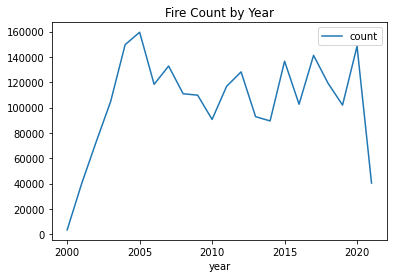

In [25]:
# Analyze fire frequency change across the US
# Fire frequency by year
fireByYear = fireData\
    .groupBy("year")\
    .count()\
    .orderBy("year")

fireByYear.show(22)

# Visualization of fire frequency by year
import pandas as pd
import matplotlib.pyplot as plt

pdDF1 = fireByYear.toPandas()
pdDF1.plot(kind = 'line',
           x = 'year',
           y = 'count',
           title = 'Fire Count by Year')



+----+----+-----+-----+-----+----+-----+-----+-----+-----+-----+----+----+
|year|   1|    2|    3|    4|   5|    6|    7|    8|    9|   10|  11|  12|
+----+----+-----+-----+-----+----+-----+-----+-----+-----+-----+----+----+
|2000|null| null| null| null|null| null| null| null| null| null|2373|1025|
|2001|1286| 1809| 2627| 4258|2613|  718| 2546| 7151| 4472| 6641|4516|1312|
|2002|1151| 2597| 1889| 3477|3848| 7828|13817|16628| 7071| 5738|6169|2661|
|2003|4537| 2988| 7822|12921|3230| 6583|12339|14080|12468|18133|6430|3254|
|2004|3778| 4093|14116|11076|4207|21526|30395|34720|10200| 7542|4743|3267|
|2005|3856| 4099|11602|13801|4966|16874|18416|49073| 9490|14245|8770|4281|
|2006|5463| 6627|13204|12797|5904| 6935|12839|15405|17485|10588|6831|4285|
|2007|2651| 8296|13465| 9936|7105| 5214|18673|26640|14487|13524|8794|4003|
|2008|3649| 6798|12257|13670|5920|11542|15098| 9268| 8893|12421|8612|2787|
|2009|5634| 8605|12254|16587|5624| 5577|21626|15817| 6881| 4124|5887|1188|
|2010|2682| 3363|13073|14

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faf7559b7d0>,
      dtype=object)

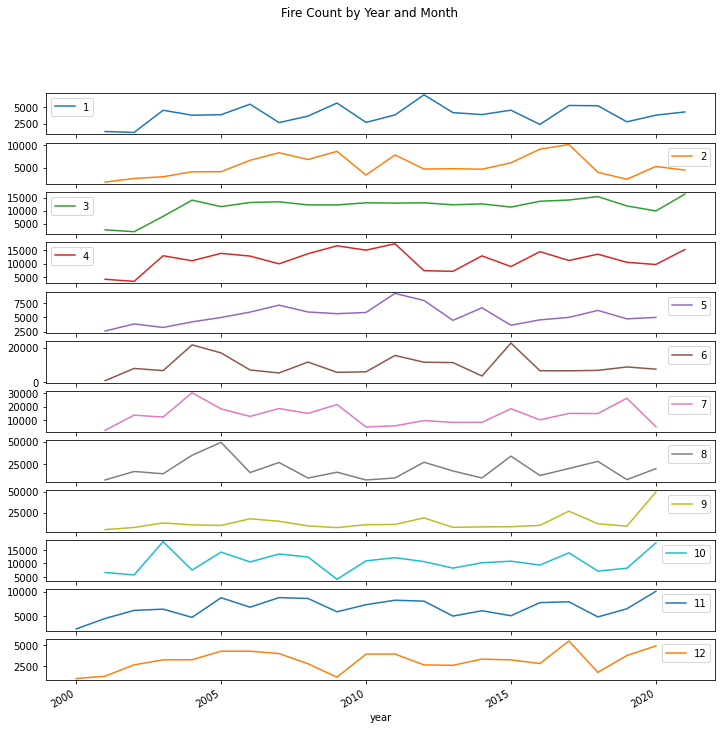

In [28]:
# Fire frequency by month and year
fireByMonthYear = fireData\
    .groupBy("year")\
    .pivot("month")\
    .count()\
    .orderBy("year")

fireByMonthYear.show()

# Visualization of fire frequency by year and month

pdDF2 = fireByMonthYear.toPandas()
pdDF2.set_index('year', inplace = True)
pdDF2.head()
pdDF2.plot(kind = 'line',
           title = 'Fire Count by Year and Month',
           figsize = (12, 12),
           subplots = True)

# Did not see a consistent pattern of the changes in fire frequency in month accorss the US
# We will partition the data by locations to see if we can see a pattern

In [42]:
# Fire frequency by location, year, month
fireByLocYearMonth = fireData\
    .withColumn("latRange", floor(col("latitude")/5) * 5)\
    .withColumn("lngRange", floor(col("longitude")/5) * 5)\
    .selectExpr("(latRange , lngRange) as georegion", "year", "month")\
    .groupBy("georegion", "year", "month")\
    .count()\
    .orderBy(desc("count"))

fireByLocYearMonth.show()

fireByLocYearMonth.select("georegion").distinct().count()


+----------+----+-----+-----+
| georegion|year|month|count|
+----------+----+-----+-----+
|{40, -125}|2020|    9|16688|
|{45, -120}|2015|    8|13300|
|{65, -150}|2004|    8|11813|
|{60, -160}|2005|    8|10864|
|{65, -145}|2005|    8| 9506|
|{35, -125}|2020|    9| 9034|
|{65, -150}|2004|    7| 8952|
|{45, -115}|2007|    8| 8638|
|{65, -145}|2019|    7| 8431|
|{35, -120}|2020|    9| 8380|
|{65, -150}|2005|    8| 8178|
|{35, -125}|2020|    8| 8131|
|{65, -150}|2004|    6| 7901|
|{40, -125}|2018|    8| 7586|
|{60, -145}|2004|    8| 7447|
|{40, -125}|2017|    8| 7333|
|{35, -100}|2009|    4| 6761|
|{45, -115}|2017|    9| 6632|
|{40, -120}|2012|    8| 6541|
|{65, -155}|2015|    7| 6455|
+----------+----+-----+-----+
only showing top 20 rows



75